In [62]:
import sys
import os
import gc
import re
import json
import copy

# Scientific Libraries
import numpy as np
import pandas as pd
from scipy.stats import beta

# Optimization
from gurobipy import Model, GRB, quicksum

# Graph & Plotting
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import contextily as ctx

# GIS & Geometry
import geopandas as gpd
from shapely.geometry import LineString

# Local Module
import batch

%matplotlib inline

gc.collect()


44240

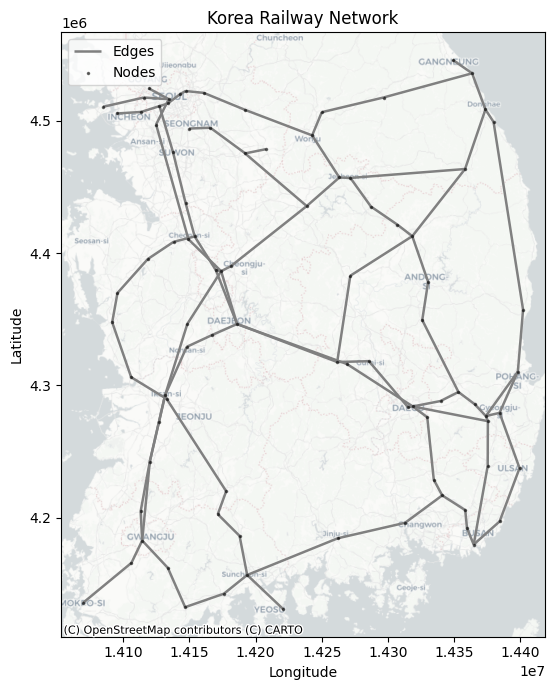

In [63]:
# Paths
toy_node_path = r"D:\MINJI\NETWORK RELIABILITY\QGIS\7.Korea_Full\shp\NODE.shp"
toy_edge_path = r"D:\MINJI\NETWORK RELIABILITY\QGIS\7.Korea_Full\shp\EDGE.shp"

# Read & project to Web Mercator (EPSG:3857)
toy_node = gpd.read_file(toy_node_path).to_crs(epsg=3857)
toy_edge = gpd.read_file(toy_edge_path).to_crs(epsg=3857)

# Plot
fig, ax = plt.subplots(figsize=(7, 7))
toy_edge.plot(ax=ax, color="grey", linewidth=1.8, label="Edges")

# Plot nodes
toy_node.plot(ax=ax, color="black", markersize=2.3, label="Nodes", zorder=3, alpha=0.5)

# Add basemap — use extent of the plotted features
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=toy_edge.crs)

# Decorations
ax.set_title("Korea Railway Network")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.legend()
plt.tight_layout()
plt.show()


====== Node info ======
n90 (ID: 90): (14220973.722359, 4130645.024699)
n89 (ID: 89): (14146717.100649, 4132230.850867)
n88 (ID: 88): (14069555.081924, 4135563.205243)
n87 (ID: 87): (14176063.932488, 4142425.232937)
n86 (ID: 86): (14193634.040681, 4156553.213346)
n85 (ID: 85): (14133595.120358, 4161955.794115)
n84 (ID: 84): (14106102.458275, 4165750.415781)
n83 (ID: 83): (14364964.734294, 4179610.177365)
n82 (ID: 82): (14114209.919848, 4182618.141239)
n81 (ID: 81): (14262065.814782, 4184305.294959)
n80 (ID: 80): (14187881.60784, 4186131.108938)
n79 (ID: 79): (14359921.684878, 4191814.358808)
n78 (ID: 78): (14313076.547757, 4196036.78356)
n76 (ID: 76): (14171404.111818, 4202524.330698)
n75 (ID: 75): (14113052.598481, 4204750.16163)
n74 (ID: 74): (14358584.399463, 4205643.497223)
n73 (ID: 73): (14341165.230242, 4216763.431199)
n72 (ID: 72): (14177745.987252, 4219927.831905)
n71 (ID: 71): (14334781.476341, 4228592.823673)
n68 (ID: 68): (14119979.491602, 4242381.548748)
n67 (ID: 67): (1412

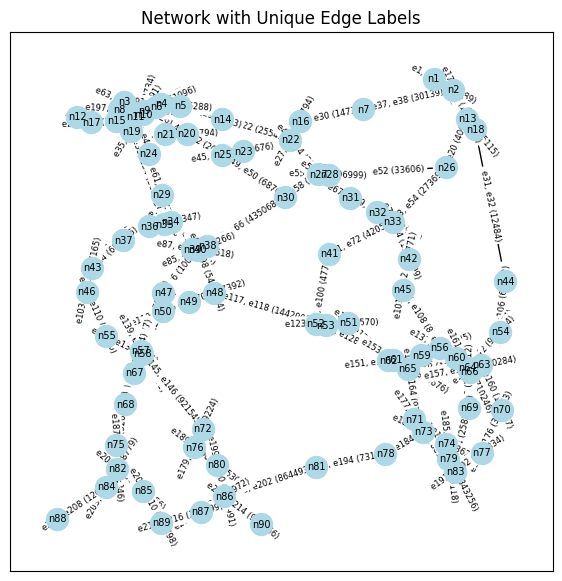

In [64]:
# 1. Node numbering (n1, n2, ...)
round_coord = lambda coord: (round(coord[0], 6), round(coord[1], 6))
node_info_list = [
    (row.node_id, round_coord((row.geometry.x, row.geometry.y)))
    for row in toy_node.itertuples()
]

nodes = {}
node_meta = []

for node_id, coord in node_info_list:
    node_name = f"n{int(node_id)}"
    nodes[node_name] = coord
    node_meta.append({
        "node_id": int(node_id),
        "node_name": node_name,
        "geometry": coord
    })

coord_to_node = {coord: node_name for node_name, coord in nodes.items()}

print("====== Node info ======")
for meta in node_meta:
    print(f"{meta['node_name']} (ID: {meta['node_id']}): {meta['geometry']}")

# 2. Edge numbering (e1, e2, ...)
nodeid_to_nodename = {meta["node_id"]: meta["node_name"] for meta in node_meta}
toy_edge['from_node_name'] = toy_edge['from_node_'].map(nodeid_to_nodename)
toy_edge['to_node_name'] = toy_edge['to_node_id'].map(nodeid_to_nodename)

edge_pairs = set()
for _, row in toy_edge.iterrows():
    sorted_pair = tuple(sorted([row['from_node_name'], row['to_node_name']]))
    edge_pairs.add(sorted_pair)

sorted_edge_pairs = sorted(edge_pairs, key=lambda x: (x[0], x[1]))

edges = {}
edge_number = 1
for from_node, to_node in sorted_edge_pairs:
    edges[f"e{edge_number}"] = (from_node, to_node)
    edges[f"e{edge_number + 1}"] = (to_node, from_node)
    edge_number += 2

# Create bidirectional edge dataframe
edge_records = []
for edge_name, (from_node, to_node) in edges.items():
    match = toy_edge[((toy_edge['from_node_name'] == from_node) & (toy_edge['to_node_name'] == to_node)) |
                     ((toy_edge['from_node_name'] == to_node) & (toy_edge['to_node_name'] == from_node))]

    journeys = match.iloc[0]['journeys'] if not match.empty else None
    geometry = match.iloc[0]['geometry'] if not match.empty else None

    edge_records.append({
        'edge_name': edge_name,
        'from_node_name': from_node,
        'to_node_name': to_node,
        'journeys': journeys,
        'geometry': geometry
    })

toy_edge_bidirectional = pd.DataFrame(edge_records)
toy_edge_bidirectional['edge_num'] = toy_edge_bidirectional['edge_name'].str.extract(r'e(\d+)').astype(int)
toy_edge_bidirectional = toy_edge_bidirectional.sort_values(by='edge_num').reset_index(drop=True)
toy_edge_bidirectional = toy_edge_bidirectional.drop(columns='edge_num')

print("\n====== Edge info ======")
pd.set_option('display.max_rows', None)
print(toy_edge_bidirectional)

# 3. Convert edges to arc format
arcs = [(u, v) for _, (u, v) in edges.items()]

# 4. Compute Euclidean distances
def euclidean_distance(node1, node2):
    x1, y1 = nodes[node1]
    x2, y2 = nodes[node2]
    return round(((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5, 2)

arc_distance = {edge_name: euclidean_distance(u, v) for edge_name, (u, v) in edges.items()}

# 5. Create a network graph
G = nx.DiGraph()

# Add nodes and edges
for node, position in nodes.items():
    G.add_node(node, pos=position)

for edge_name, (u, v) in edges.items():
    G.add_edge(u, v, weight=arc_distance[edge_name])

# Build edge label map for plotting
unique_edges = set()
edge_name_map = {}

for edge_name, (u, v) in edges.items():
    if (v, u) not in unique_edges:
        unique_edges.add((u, v))

        reverse_edge_name = [k for k, (a, b) in edges.items() if (a, b) == (v, u)]
        journeys = toy_edge_bidirectional[
            (toy_edge_bidirectional['from_node_name'] == u) &
            (toy_edge_bidirectional['to_node_name'] == v)
        ]['journeys'].values

        journeys_val = int(journeys[0]) if len(journeys) > 0 else "?"
        edge_label = f"{edge_name}, {reverse_edge_name[0]} ({journeys_val})" if reverse_edge_name else edge_name

        edge_name_map[(u, v)] = edge_label

# Plot the network topology
plt.figure(figsize=(7, 7))
pos = nx.get_node_attributes(G, 'pos')
nx.draw_networkx_nodes(G, pos, node_size=250, node_color="lightblue")
nx.draw_networkx_edges(
    G, pos,
    edgelist=list(unique_edges),
    arrowstyle='-',
    min_target_margin=10,
    min_source_margin=10
)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_name_map, font_size=6)
nx.draw_networkx_labels(G, pos, font_size=7)
plt.title("Network with Unique Edge Labels")
plt.show()


In [65]:
nodes = nodes  
edges = edges  
arcs = arcs
arc_distance = arc_distance 

# 1. Generate arc failure probabilities based on arc distances (longer distance -> higher failure probability)
min_dist = min(arc_distance.values())
max_dist = max(arc_distance.values())

min_prob = 0.01
max_prob = 0.3

def compute_failure_probability(distance, min_dist, max_dist, min_prob, max_prob):
    normalized_dist = (distance - min_dist) / (max_dist - min_dist)
    return round(min_prob + normalized_dist * (max_prob - min_prob), 4)

probs_dynamic = {
    edge: {
        0: compute_failure_probability(dist, min_dist, max_dist, min_prob, max_prob),
        1: round(1 - compute_failure_probability(dist, min_dist, max_dist, min_prob, max_prob), 4)
    }
    for edge, dist in arc_distance.items()
}

def numeric_sort(edge):
    return int(edge[1:])

probs_sorted = {k: probs_dynamic[k] for k in sorted(probs_dynamic, key=numeric_sort)}

probs = probs_sorted
probs_cpm = copy.deepcopy(probs)

# 2. Assign capacities to each arcs
intact_capacity = {}

for edge_name, (u, v) in edges.items():
    match = toy_edge[((toy_edge['from_node_name'] == u) & (toy_edge['to_node_name'] == v)) |
                     ((toy_edge['from_node_name'] == v) & (toy_edge['to_node_name'] == u))]

    if not match.empty:
        intact_capacity[edge_name] = match.iloc[0]['journeys']
    else:
        intact_capacity[edge_name] = None  

print("Intact Capacities:", intact_capacity)

def generate_comps_st(probs):
    comps_st = {}

    edge_keys = sorted([e for e in probs if e[1:].isdigit()], key=lambda x: int(x[1:]))

    for i in range(0, len(edge_keys) - 1, 2):
        e1 = edge_keys[i]
        e2 = edge_keys[i + 1]

        prob = probs.get(e1, {})
        if not isinstance(prob, dict) or 0 not in prob or 1 not in prob:
            print(f"⚠️ Invalid probability format for {e1}: {prob}")
            continue

        state = np.random.choice([0, 1], p=[prob[0], prob[1]])

        comps_st[e1] = state
        comps_st[e2] = state

    return comps_st

Intact Capacities: {'e1': np.float64(1802689.2), 'e2': np.float64(1802689.2), 'e3': np.float64(10047687.92307873), 'e4': np.float64(10047687.92307873), 'e5': np.float64(5392253.385889263), 'e6': np.float64(5392253.385889263), 'e7': np.float64(23073734.13660661), 'e8': np.float64(23073734.13660661), 'e9': np.float64(2779869.110474105), 'e10': np.float64(2779869.110474105), 'e11': np.float64(9634014.67605409), 'e12': np.float64(9634014.67605409), 'e13': np.float64(770399.9999999999), 'e14': np.float64(770399.9999999999), 'e15': np.float64(45115.63756648837), 'e16': np.float64(45115.63756648837), 'e17': np.float64(1088809.436433481), 'e18': np.float64(1088809.436433481), 'e19': np.float64(400801.9089924574), 'e20': np.float64(400801.9089924574), 'e21': np.float64(2554316.642963238), 'e22': np.float64(2554316.642963238), 'e23': np.float64(2957753.213511791), 'e24': np.float64(2957753.213511791), 'e25': np.float64(1203128.4), 'e26': np.float64(1203128.4), 'e27': np.float64(256794.2983568404

Text(81.94444444444444, 0.5, 'Latitude')

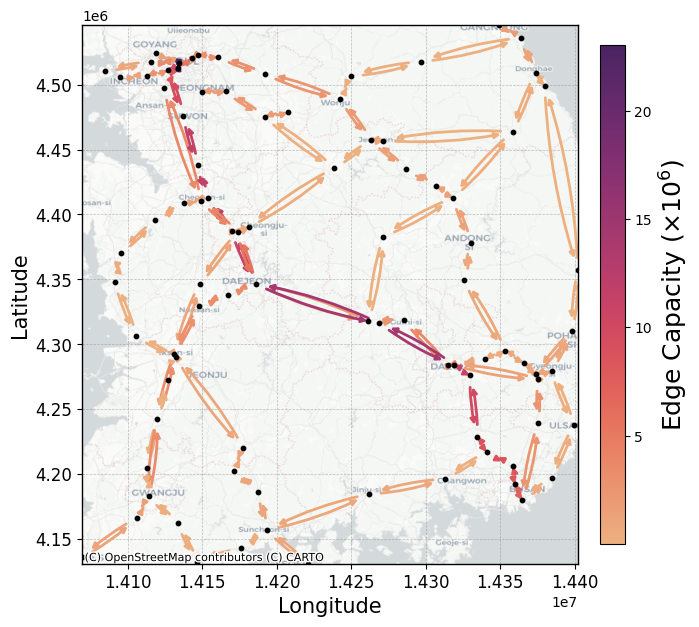

In [66]:
toy_node = toy_node.to_crs(epsg=3857)
pos = {f"n{int(row.node_id)}": (row.geometry.x, row.geometry.y)
       for row in toy_node.itertuples()}
for node_name, xy in pos.items():
    G.nodes[node_name]["pos"] = xy

# Colormap setup
flare_cmap = sns.color_palette("flare", as_cmap=True)

# Normalize capacity values (unit: ×10⁶)
cap_vals = [v for v in intact_capacity.values() if v is not None]
cap_vals_scaled = [v / 1e6 for v in cap_vals]
cmin, cmax = min(cap_vals_scaled), max(cap_vals_scaled)
norm = mpl.colors.Normalize(vmin=cmin, vmax=cmax)

pos = nx.get_node_attributes(G, "pos")
fig, ax = plt.subplots(figsize=(7, 7))

# Compute plot extent for basemap
xs = [xy[0] for xy in pos.values()]
ys = [xy[1] for xy in pos.values()]
xmin, xmax = min(xs), max(xs)
ymin, ymax = min(ys), max(ys)

# Draw edges with color based on capacity
for edge_name, (u, v) in edges.items():
    cap = intact_capacity.get(edge_name, 0) / 1e6
    color = flare_cmap(norm(cap))
    nx.draw_networkx_edges(
        G, pos,
        edgelist=[(u, v)],
        ax=ax,
        edge_color=[color],
        width=2,
        arrowstyle="-|>",
        arrowsize=8,
        connectionstyle="arc3,rad=0.07",
        alpha=1.0
    )

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=10, node_color="black", ax=ax)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs="EPSG:3857", zorder=0)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Show axis frame
ax.set_frame_on(True)
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_color('black')
    spine.set_zorder(3)

# Add colorbar
sm = mpl.cm.ScalarMappable(cmap=flare_cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label(r"Edge Capacity ($\times 10^6$)", fontsize=18)

# Axis ticks, grid, and labels
ax.tick_params(
    axis='both', which='both',
    bottom=True, top=False,
    left=True, right=False,
    labelbottom=True, labelleft=True,
    labelsize=12, direction='out'
)
ax.set_axisbelow(True)
ax.grid(True, which='major', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
ax.set_xlabel("Longitude", fontsize=15)
ax.set_ylabel("Latitude", fontsize=15)

Maximum Allowable Distance Per OD Pair:

k1:
  - Origin → Destination: n2 → n7
  - Base Distance: 55063.45 m
  - Max Allowable Distance: 55510.45 m

k2:
  - Origin → Destination: n2 → n16
  - Base Distance: 93154.39 m
  - Max Allowable Distance: 93601.39 m

k3:
  - Origin → Destination: n2 → n22
  - Base Distance: 108189.77 m
  - Max Allowable Distance: 108636.77 m

k4:
  - Origin → Destination: n7 → n16
  - Base Distance: 38090.93 m
  - Max Allowable Distance: 38537.93 m

k5:
  - Origin → Destination: n7 → n22
  - Base Distance: 53126.32 m
  - Max Allowable Distance: 53573.32 m

k6:
  - Origin → Destination: n16 → n22
  - Base Distance: 15035.39 m
  - Max Allowable Distance: 15482.39 m

k7:
  - Origin → Destination: n22 → n16
  - Base Distance: 15035.39 m
  - Max Allowable Distance: 15482.39 m

k8:
  - Origin → Destination: n22 → n7
  - Base Distance: 53126.32 m
  - Max Allowable Distance: 53573.32 m

k9:
  - Origin → Destination: n22 → n2
  - Base Distance: 108189.77 m
  - Max Allowa

C:\Users\Minji Kang\AppData\Local\Temp\ipykernel_9884\1471907489.py:125: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


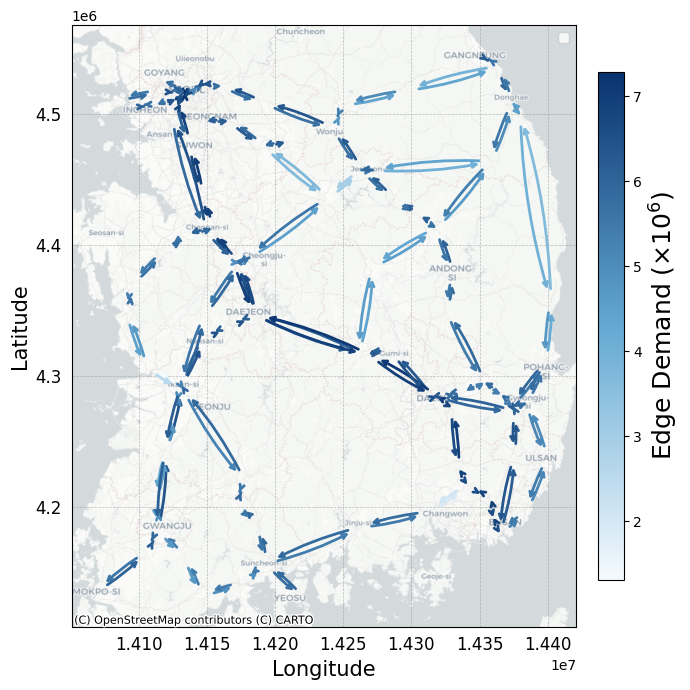

In [67]:
# Build directed graph with weighted arcs
G = nx.DiGraph()
for node, position in nodes.items():
    G.add_node(node, pos=position)

for edge_id, (u, v) in edges.items():
    G.add_edge(u, v, weight=arc_distance[edge_id])

# Initialize demand for each arc
edge_demand = { (u, v): 0 for u, v in G.edges }


# 3. Compute maximum allowable distance
json_path = r"D:\MINJI\NETWORK RELIABILITY\QGIS\7.Korea_Full\5.demand_data_kofull.json"
with open(json_path, "r", encoding="utf-8") as f:
    demand = json.load(f)

demand_dict = {}
max_distance = {}
avg_velo = 149  # Speed in km/h
commodity_name_map = {}  
delay_time = 180

for idx, item in enumerate(demand, start=1):
    key = f"k{idx}"
    demand_dict[key] = {
        "origin": item["origin_name"],
        "destination": item["destination_name"],
        "amount": item["journeys"],
        "distance": item["distance"]
    }
    max_allowable_ad_distance = avg_velo * delay_time / 60
    max_distance[key] = item["distance"] + max_allowable_ad_distance 

print("Maximum Allowable Distance Per OD Pair:\n")

for k in max_distance:
    base_dist = demand_dict[k]['distance']
    extra_dist = round(max_distance[k] - base_dist, 2)
    print(f"{k}:")
    print(f"  - Origin → Destination: {demand_dict[k]['origin']} → {demand_dict[k]['destination']}")
    print(f"  - Base Distance: {base_dist:.2f} m")
    print(f"  - Max Allowable Distance: {max_distance[k]:.2f} m\n")


# Accumulate demand from all shortest paths
for info in demand:
    origin = info["origin_name"]        
    destination = info["destination_name"]
    amount = info["journeys"]            

    try:
        paths = list(nx.all_shortest_paths(G, source=origin, target=destination, weight="weight"))
        for path in paths:
            for i in range(len(path) - 1):
                edge = (path[i], path[i + 1])
                if edge in edge_demand:
                    edge_demand[edge] += amount
                    print(f"OD {origin} → {destination}, amount={amount} ➜ edge {edge} += {amount} (total: {edge_demand[edge]})")
    except nx.NetworkXNoPath:
        print(f"No path found for {origin} → {destination}")
        continue

# Log-scaled normalization
normalized_demand = {
    (u, v): np.log10(d + 1) for (u, v), d in edge_demand.items()
}
D_max = max(normalized_demand.values())
D_min = min(normalized_demand.values())

normalized_demand = {
    (u, v): (val - D_min) / (D_max - D_min)
    for (u, v), val in normalized_demand.items()
}

# Visualization
from matplotlib.colors import LinearSegmentedColormap
start_rgb = (245/255, 250/255, 254/255)    
mid_rgb   = (100/255, 169/255, 211/255)       
end_rgb   = (8/255, 50/255, 110/255)    
cmap = LinearSegmentedColormap.from_list("custom_3color_gradient", [start_rgb, mid_rgb, end_rgb])

pos = nx.get_node_attributes(G, "pos")
fig, ax = plt.subplots(figsize=(7, 7))

edge_labels = {
    (u, v): f"{edge_demand[(u, v)]:.0f}"
    for (u, v) in G.edges
    if edge_demand[(u, v)] > 0
}

for (u, v), value in normalized_demand.items():
    color = cmap(value)
    nx.draw_networkx_edges(
        G, pos, edgelist=[(u, v)],
        width=2,
        edge_color=[color],
        arrowstyle="->",
        arrowsize=8,
        alpha=1,
        ax=ax,
        connectionstyle="arc3,rad=0.07"
    )

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs="EPSG:3857", zorder=0)
ax.tick_params(labelbottom=True, labelleft=True)
ax.set_axis_on()
ax.ticklabel_format(useOffset=False)

# Colorbar
norm = mpl.colors.Normalize(vmin=D_min, vmax=D_max)
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label(r"Edge Demand ($\times 10^6$)", fontsize=18)


# Grid
ax.grid(True, which='major', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
ax.tick_params(axis='both', which='major', labelsize=12, direction='out')
ax.set_axisbelow(True)  

plt.xlabel("Longitude", fontsize=15)
plt.ylabel("Latitude", fontsize=15)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from gurobipy import Model, GRB, quicksum

def MCNF_timeexpanded(N, A, edges,                    # 노드·아크·edge_id↔(i,j)
                            demand, max_distance,           # demand dict: {k:{origin, destination, amount}}
                            arc_capacity, arc_distance,     # 용량·거리
                            tau,                            # τ[(i,j)] in minutes
                            Tmax=60, dt=1,                  # 분석 시간 1h, 1분 그리드
                            threshold_ratio=0.05,
                            Xstate=None):                   # {edge_id:0/1} 고장표

    # ── 준비 ──────────────────────────────────────────────
    Tset = range(0, Tmax + 1, dt)
    Feas = [((i, j), t) for (i, j) in A for t in Tset if t + tau[(i, j)] <= Tmax]

    m = Model("TE_MCNF")
    m.setParam("OutputFlag", 0)

    # ── 변수 ──────────────────────────────────────────────
    g, f, y, u = {}, {}, {}, {}
    for k, info in demand.items():
        qk, sk, tk = info["amount"], info["origin"], info["destination"]

        for n in N:
            for tt in Tset:
                g[k, n, tt] = m.addVar(lb=0, name=f"g_{k}_{n}_{tt}")

        y[k] = m.addVar(lb=0, name=f"y_{k}")
        u[k] = m.addVar(lb=0, name=f"u_{k}")

        for (i, j), tt in Feas:
            e_id = next(e for e, v in edges.items() if v == (i, j))
            cap = arc_capacity[e_id]
            if Xstate and Xstate.get(e_id, 1) == 0:
                cap = 0
            f[k, i, j, tt] = m.addVar(lb=0, ub=cap, name=f"f_{k}_{i}_{j}_{tt}")

        # (a) 초기 재고
        m.addConstr(g[k, sk, 0] == qk)
        for n in N - {sk}:
            m.addConstr(g[k, n, 0] == 0)

    # ── (b) 시간별 수지 ────────────────────────────────────
    for k, info in demand.items():
        sk, tk = info["origin"], info["destination"]
        for tt in Tset[:-1]:
            for n in N:
                inflow = quicksum(
                    f[k, j, n, tt - tau[(j, n)]]
                    for (j, n2), t0 in Feas
                    if n2 == n and t0 == tt - tau[(j, n)]
                )
                outflow = quicksum(
                    f[k, n, j, tt]
                    for (n2, j), t0 in Feas
                    if n2 == n and t0 == tt
                )
                m.addConstr(g[k, n, tt + dt] == g[k, n, tt] + inflow - outflow)

    # ── (d)(e) 도착·미도착 ─────────────────────────────────
    for k, info in demand.items():
        tk = info["destination"]
        m.addConstr(y[k] == g[k, tk, Tmax])
        m.addConstr(u[k] == info["amount"] - y[k])

    # ── (c) 아크 용량 ─────────────────────────────────────
    for (i, j), tt in Feas:
        e_id = next(e for e, v in edges.items() if v == (i, j))
        m.addConstr(quicksum(f[k, i, j, tt] for k in demand) <= arc_capacity[e_id])

    # ── 목적식 ────────────────────────────────────────────
    m.setObjective(quicksum(u[k] for k in demand), GRB.MINIMIZE)
    m.optimize()

    # ── 결과 정리 ─────────────────────────────────────────
    if m.status != GRB.OPTIMAL:
        return None, None, None, None

    expected_loss = m.objVal
    total_demand = sum(info["amount"] for info in demand.values())
    threshold = total_demand * threshold_ratio
    sys_st = "s" if expected_loss < threshold else "f"

    edge_flows = {e: 0.0 for e in edges}
    for (k, i, j, tt), var in f.items():
        if var.X > 0:
            e_id = next(e for e, v in edges.items() if v == (i, j))
            edge_flows[e_id] += var.X   # 시간 누계

    return expected_loss, sys_st, threshold, edge_flows


In [ ]:
failed = []

comps_st = {e: (0 if int(e[1:]) in failed else 1) for e in intact_capacity}
arc_capacity = {e: float(intact_capacity[e]) * comps_st[e] for e in intact_capacity}
print(arc_capacity)

sys_fun_mcnf = lambda comps_st: MCNF_timeexpanded(
    arcs=arcs,
    comps_st=comps_st,
    edges=edges,
    arc_capacity=arc_capacity,
    demand=demand_dict,
    max_distance=max_distance,
    arc_distance=arc_distance, 
    threshold_ratio=0.13
)

print("\n🔹 Input Values:")
print("Component States (comps_st):", comps_st)
print("Edges:", edges)
print("Arc Capacity:", arc_capacity)
print("Demand:", demand_dict)
print("Max Distance:", max_distance)
print("Arc Distance:", arc_distance)

expected_loss_mcnf, sys_st_mcnf, min_comps_st_mcnf, threshold_mcnf, edge_flows_mcnf = sys_fun_mcnf(comps_st)

print("\n🔹 Edge Flows:")
if edge_flows_mcnf:
    for e, f in edge_flows_mcnf.items():
        if f > 0:
            print(f"{e}: {f:.2f}")
else:
    print("No valid flows.")

print("\n🔹 Output Values:")
print("System State (MCNF):", sys_st_mcnf)
print("Minimum component state (MCNF):", min_comps_st_mcnf) 
print("Expected Loss (MCNF):", expected_loss_mcnf) 
print("threshold (MCNF):", threshold_mcnf)

{'e1': 1802689.2, 'e2': 1802689.2, 'e3': 10047687.92307873, 'e4': 10047687.92307873, 'e5': 5392253.385889263, 'e6': 5392253.385889263, 'e7': 23073734.13660661, 'e8': 23073734.13660661, 'e9': 2779869.110474105, 'e10': 2779869.110474105, 'e11': 9634014.67605409, 'e12': 9634014.67605409, 'e13': 770399.9999999999, 'e14': 770399.9999999999, 'e15': 45115.63756648837, 'e16': 45115.63756648837, 'e17': 1088809.436433481, 'e18': 1088809.436433481, 'e19': 400801.9089924574, 'e20': 400801.9089924574, 'e21': 2554316.642963238, 'e22': 2554316.642963238, 'e23': 2957753.213511791, 'e24': 2957753.213511791, 'e25': 1203128.4, 'e26': 1203128.4, 'e27': 256794.2983568404, 'e28': 256794.2983568404, 'e29': 147310.3186947427, 'e30': 147310.3186947427, 'e31': 12484.36243351163, 'e32': 12484.36243351163, 'e33': 3634570.908184495, 'e34': 3634570.908184495, 'e35': 8061091.483615398, 'e36': 8061091.483615398, 'e37': 30139.91901781049, 'e38': 30139.91901781049, 'e39': 1713794.4, 'e40': 1713794.4, 'e41': 2071739.929

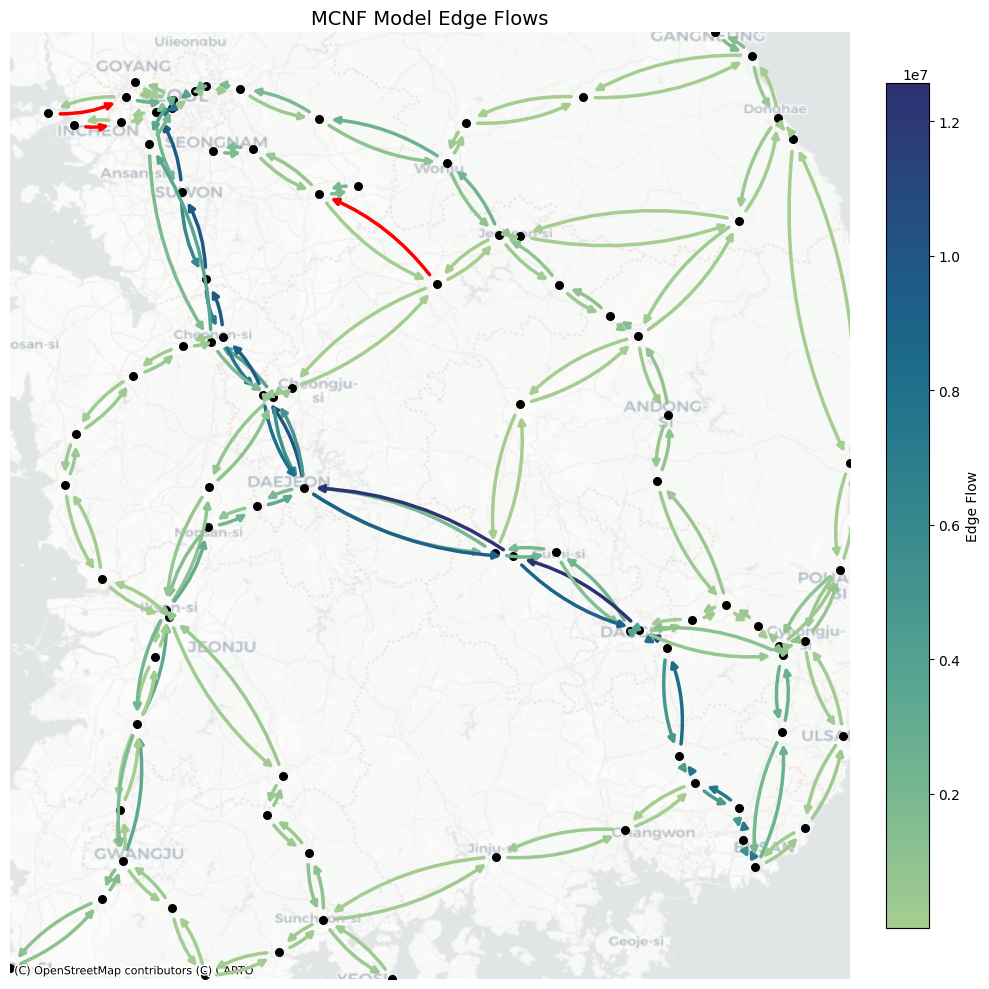

 No edges to plot.


In [70]:
# 2) networkx 그래프 생성
G_mcnf = nx.DiGraph()
G_sp   = nx.DiGraph()

for node, pos in nodes.items():
    G_mcnf.add_node(node, pos=pos)
    G_sp.add_node(node,   pos=pos)

pos_mcnf = nx.get_node_attributes(G_mcnf, "pos")
pos_sp   = nx.get_node_attributes(G_sp, "pos")

# nodes, edges 변수는 기존에 정의된 것을 그대로 사용
for node, pos in nodes.items():
    G_mcnf.add_node(node, pos=pos)
    G_sp.add_node(node,   pos=pos)

# flow > 0인 에지만 그래프에 추가
for edge_name, (u, v) in edges.items():
    flow_m = edge_flows_mcnf.get(edge_name, 0)
    if flow_m >= 0:
        G_mcnf.add_edge(u, v, weight=flow_m)

pos = nodes  # EPSG:3857 좌표 dict

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import contextily as ctx
import networkx as nx

# 🔁 edges의 key를 정렬하여 2개씩 짝짓기
sorted_edge_keys = sorted(edges.keys(), key=lambda x: int(x[1:]))  # "e1", "e2" → 1, 2
edge_directions = {}

for i in range(0, len(sorted_edge_keys) - 1, 2):  # 2개씩
    e1 = sorted_edge_keys[i]
    e2 = sorted_edge_keys[i + 1]

    u1, v1 = edges[e1]
    u2, v2 = edges[e2]

    # 두 edge가 서로 반대방향일 때만 등록
    if (u1, v1) == (v2, u2):  # 양방향 확인
        edge_directions[(u1, v1)] =  0.15  # 곡률 +
        edge_directions[(u2, v2)] = 0.15  # 곡률 -
    else:
        print(f" 경고: {e1}와 {e2}는 반대 방향이 아닙니다. 건너뜁니다.")


def plot_both_dirs(G, pos, edge_directions=None, title="Directed Edge Flow Plot"):
    edge_list = list(G.edges())
    flows = [G[u][v]['weight'] for u, v in edge_list if 'weight' in G[u][v] and G[u][v]['weight'] > 0]
    if not edge_list:
        print(" No edges to plot.")
        return

    norm = mpl.colors.Normalize(vmin=min(flows) if flows else 0, vmax=max(flows) if flows else 1)
    cmap = sns.color_palette("crest", as_cmap=True)

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_facecolor('white')

    xs = [p[0] for p in pos.values()]
    ys = [p[1] for p in pos.values()]
    ax.set_xlim(min(xs), max(xs))
    ax.set_ylim(min(ys), max(ys))
    ctx.add_basemap(ax, crs="EPSG:3857", source=ctx.providers.CartoDB.Positron, alpha=0.7)

    for u, v in edge_list:
        flow_val = G[u][v].get('weight', 0)
        rad = edge_directions.get((u, v), 0.0) if edge_directions else 0.0

        if flow_val == 0:
            edge = nx.draw_networkx_edges(
                G, pos,
                edgelist=[(u, v)],
                width=2.5,
                edge_color='red',
                connectionstyle=f"arc3,rad={rad}",
                arrows=True,
                ax=ax
            )
            for line in edge:
                line.set_zorder(2)
        else:
            color = cmap(norm(flow_val))
            edge = nx.draw_networkx_edges(
                G, pos,
                edgelist=[(u, v)],
                width=2.5,
                edge_color=[color],
                connectionstyle=f"arc3,rad={rad}",
                arrows=True,
                ax=ax
            )
            for line in edge:
                line.set_zorder(3)

    nx.draw_networkx_nodes(G, pos, node_color='black', node_size=30, ax=ax)

    if flows:
        sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array(flows)
        fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04).set_label("Edge Flow")

    ax.set_title(title, fontsize=14)
    ax.axis('off')
    plt.tight_layout()
    plt.show()



# 호출 예시
plot_both_dirs(G_mcnf, pos_mcnf, edge_directions=edge_directions, title="MCNF Model Edge Flows")
plot_both_dirs(G_sp, pos_sp, edge_directions=edge_directions, title="Shortest Path Edge Flows")